In [1]:
# Let's load the required libs.
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, LeakyReLU
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.convolutional import Conv1D, MaxPooling1D
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

C:\Users\lenovo\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Example 2: export_dataframe
In this example we wish to make forcasts on a time series of international airline passengers.

Loading and plotting the data

In [2]:
export_dataframe_1 = pd.read_excel('export_dataframe.xlsx')

In [3]:
export_dataframe=export_dataframe_1
export_dataframe=export_dataframe.groupby(pd.Grouper(key='Date Opération', axis=0, freq='D')).sum()
export_dataframe.head(3)

,Dossier,Poids Taxable,Catégorie,Prévision,Réalisation,N° Achat,prev_resultat
Date Opération,,,,,,,
2017-01-02,1.862371e+10,720389.00,3367,10936.146190,10866.671905,2057463002,69.474286
2017-01-03,1.288171e+10,507856.00,1781,10097.422857,10090.737143,1259284920,6.685714
2017-01-04,2.608677e+10,1267171.63,4703,17320.157619,17306.176667,2839801236,13.980952


In [4]:
export_dataframe=export_dataframe.drop(columns=['Dossier', 'Poids Taxable','Catégorie','Prévision','N° Achat','prev_resultat'])

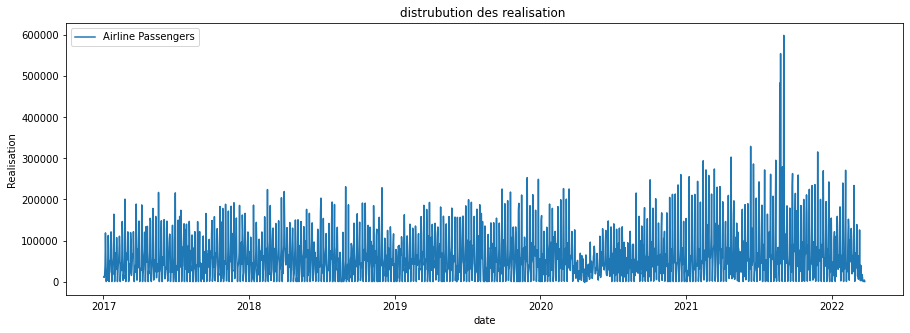

In [5]:
# Create a time series plot.
plt.figure(figsize = (15, 5))
plt.plot(export_dataframe, label = "Airline Passengers")
plt.xlabel("date")
plt.ylabel("Realisation")
plt.title("distrubution des realisation ")
plt.legend()
plt.show()

We can observe a strong upwards trend in terms of numbers of passgengers with some seasonality component. The seasonality may be understood to conincide with holiday periods, but we'd need to have a closer look at the actual time periods to confirm this.

We could also consider de-trending the time series and applying further "cleaning" techniques, which would be a prerequisite e.g. in an ARIMA setting.

However, for simplicity reasons we will just proceed with the data as is.

The only transformations we'll be doing are:

- Scale data to the  (0,1)  interval for increased numerical stability.
- Re-shape the data so we have one column as response (called  Y  in the code) and another one as predictor variable (called X in the code).

## Data Preparation

In [27]:
# Get the raw data values from the pandas data frame.
data_raw = export_dataframe.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.02165492],
       [0.02036568],
       [0.03235436],
       [0.06753884],
       [0.2004458 ]], dtype=float32)

Split into test / training data

As usual, the data gets split into training and test data so we can later assess how well the final model performs.

In [28]:
# Using 80% of data for training, 20% for validation.
TRAIN_SIZE = 0.80
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1526, 382)


Get data into shape to use in Keras

In [29]:
def create_dataset(dataset, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [30]:
# Create test and training sets for one-step-ahead regression.
window_size = 32
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(1493, 32)
New training data shape:
(1493, 32, 1)


## Build simple LSTM model on export data

The LSTM architecture here consists of:

- One input layer.
- One LSTM layer of 4 blocks.
- One Dense layer to produce a single output.
- Use MSE as loss function.

Many different architectures could be considered. But this is just a quick test, so we'll keep things nice and simple.

In [37]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)


In [90]:
look_back = 15
model11 = Sequential()
model11.add(LSTM(64,
               activation='relu',
               batch_input_shape=(batch_size, look_back, 1),
               stateful=True,
               return_sequences=False))
model11.add(Dense(1))
model11.compile(loss='mean_squared_error', optimizer='adam')

model1.summary()

# Fit the first model.
history1 = model1.fit(train_X, train_Y, epochs = 400, batch_size = 1, validation_data = (test_X, test_Y))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
1493/1493 [==============================] - 6s 4ms/step - loss: 0.0022 - val_loss: 0.0128
Epoch 2/400
1493/1493 [==============================] - 7s 5ms/step - loss: 0.0022 - val_loss: 0.0126
Epoch 3/400
1493/1493 [==============================] - 6s 4ms/step - loss: 0.0022 - val_loss: 0.0128TA: 2s - - ETA: 1s - loss: 0.002 - ETA: 1s - loss: - ETA: 0s -  - ETA: 0s - loss: 0
Epoch 4/400
1493/1493 [==============================] - 6s 4ms/step - loss: 0.0022 - val_loss: 0.0125
Epoch 5/400
1493/1493 [

1493/1493 [==============================] - 14s 10ms/step - loss: 0.0022 - val_loss: 0.0124
Epoch 150/400
1493/1493 [==============================] - 13s 9ms/step - loss: 0.0022 - val_loss: 0.0123
Epoch 151/400
1493/1493 [==============================] - 10s 7ms/step - loss: 0.0022 - val_loss: 0.0129
Epoch 152/400
1493/1493 [==============================] - 12s 8ms/step - loss: 0.0022 - val_loss: 0.0131
Epoch 153/400
1493/1493 [==============================] - 12s 8ms/step - loss: 0.0022 - val_loss: 0.0123
Epoch 154/400
1493/1493 [==============================] - 10s 7ms/step - loss: 0.0022 - val_loss: 0.0129
Epoch 155/400
1493/1493 [==============================] - 11s 7ms/step - loss: 0.0022 - val_loss: 0.0130
Epoch 156/400
1493/1493 [==============================] - 10s 7ms/step - loss: 0.0022 - val_loss: 0.0125
Epoch 157/400
1493/1493 [==============================] - 12s 8ms/step - loss: 0.0022 - val_loss: 0.0129
Epoch 158/400
1493/1493 [==============================] - 

1493/1493 [==============================] - 9s 6ms/step - loss: 0.0022 - val_loss: 0.0127
Epoch 304/400
1493/1493 [==============================] - 10s 7ms/step - loss: 0.0021 - val_loss: 0.0128
Epoch 305/400
1493/1493 [==============================] - 11s 8ms/step - loss: 0.0022 - val_loss: 0.0123
Epoch 306/400
1493/1493 [==============================] - 13s 9ms/step - loss: 0.0021 - val_loss: 0.0125
Epoch 307/400
1493/1493 [==============================] - 12s 8ms/step - loss: 0.0021 - val_loss: 0.0124
Epoch 308/400
1493/1493 [==============================] - 11s 7ms/step - loss: 0.0021 - val_loss: 0.0122
Epoch 309/400
1493/1493 [==============================] - 11s 7ms/step - loss: 0.0021 - val_loss: 0.0125
Epoch 310/400
1493/1493 [==============================] - 9s 6ms/step - loss: 0.0021 - val_loss: 0.0131
Epoch 311/400
1493/1493 [==============================] - 11s 7ms/step - loss: 0.0021 - val_loss: 0.0126
Epoch 312/400
1493/1493 [==============================] - 9s 

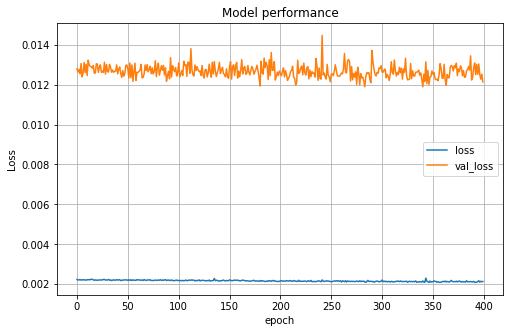

In [91]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [93]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

In [94]:
rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 27337.70 RMSE
Test data score: 66297.36 RMSE


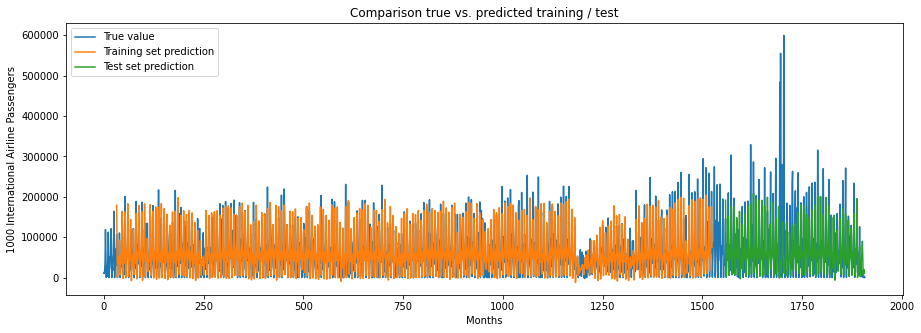

In [95]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

# Build simple GRU model 

The architecture here consists of:

One input layer.
One GRU layer of 4 blocks.
One Dense layer to produce a single output.
Use MSE as loss function.

In [38]:
window_size = 32

# Define the model.
model2 = Sequential()
model2.add(GRU(4, input_shape = (window_size, 1)))
model2.add(Dense(1))

model2.compile(loss = "mean_squared_error", optimizer = "adam")

model2.summary()

# Fit the first model.
history2 = model2.fit(train_X, train_Y, epochs = 500, batch_size = 1, validation_data = (test_X, test_Y))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 4)                 84        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1493/1493 [==============================] - 15s 10ms/step - loss: 0.0090 - val_loss: 0.0203
Epoch 2/500
1493/1493 [==============================] - 17s 11ms/step - loss: 0.0079 - val_loss: 0.0200
Epoch 3/500
1493/1493 [==============================] - 17s 12ms/step - loss: 0.0068 - val_loss: 0.0202
Epoch 4/500
1493/1493 [==============================] - 17s 11ms/step - loss: 0.0063 - val_loss: 0.0199
Epoch 5/500
1493/1493 [==============================] - 15s 10ms/step - loss: 0.0055 - val_loss: 0.

1493/1493 [==============================] - 19s 13ms/step - loss: 0.0025 - val_loss: 0.0128
Epoch 149/500
1493/1493 [==============================] - 19s 13ms/step - loss: 0.0024 - val_loss: 0.0120
Epoch 150/500
1493/1493 [==============================] - 17s 11ms/step - loss: 0.0025 - val_loss: 0.0124
Epoch 151/500
1493/1493 [==============================] - 19s 13ms/step - loss: 0.0025 - val_loss: 0.0130
Epoch 152/500
1493/1493 [==============================] - 19s 13ms/step - loss: 0.0025 - val_loss: 0.0124
Epoch 153/500
1493/1493 [==============================] - 18s 12ms/step - loss: 0.0025 - val_loss: 0.0123
Epoch 154/500
1493/1493 [==============================] - 19s 12ms/step - loss: 0.0025 - val_loss: 0.0124
Epoch 155/500
1493/1493 [==============================] - 17s 12ms/step - loss: 0.0025 - val_loss: 0.0127
Epoch 156/500
1493/1493 [==============================] - 16s 11ms/step - loss: 0.0024 - val_loss: 0.0126
Epoch 157/500
1493/1493 [==========================

1493/1493 [==============================] - 17s 11ms/step - loss: 0.0024 - val_loss: 0.0122
Epoch 301/500
1493/1493 [==============================] - 9s 6ms/step - loss: 0.0025 - val_loss: 0.0125
Epoch 302/500
1493/1493 [==============================] - 9s 6ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 303/500
1493/1493 [==============================] - 9s 6ms/step - loss: 0.0024 - val_loss: 0.0132
Epoch 304/500
1493/1493 [==============================] - 9s 6ms/step - loss: 0.0024 - val_loss: 0.0125
Epoch 305/500
1493/1493 [==============================] - 10s 7ms/step - loss: 0.0024 - val_loss: 0.0122
Epoch 306/500
1493/1493 [==============================] - 9s 6ms/step - loss: 0.0024 - val_loss: 0.0119
Epoch 307/500
1493/1493 [==============================] - 9s 6ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 308/500
1493/1493 [==============================] - 9s 6ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 309/500
1493/1493 [==============================] - 9s 6ms/

Epoch 454/500
1493/1493 [==============================] - 16s 11ms/step - loss: 0.0024 - val_loss: 0.0125
Epoch 455/500
1493/1493 [==============================] - 16s 11ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 456/500
1493/1493 [==============================] - 16s 11ms/step - loss: 0.0024 - val_loss: 0.0123
Epoch 457/500
1493/1493 [==============================] - 19s 13ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 458/500
1493/1493 [==============================] - 15s 10ms/step - loss: 0.0024 - val_loss: 0.0124
Epoch 459/500
1493/1493 [==============================] - 15s 10ms/step - loss: 0.0025 - val_loss: 0.0125
Epoch 460/500
1493/1493 [==============================] - 16s 10ms/step - loss: 0.0023 - val_loss: 0.0123
Epoch 461/500
1493/1493 [==============================] - 16s 11ms/step - loss: 0.0024 - val_loss: 0.0125
Epoch 462/500
1493/1493 [==============================] - 15s 10ms/step - loss: 0.0024 - val_loss: 0.0129
Epoch 463/500
1493/1493 [============

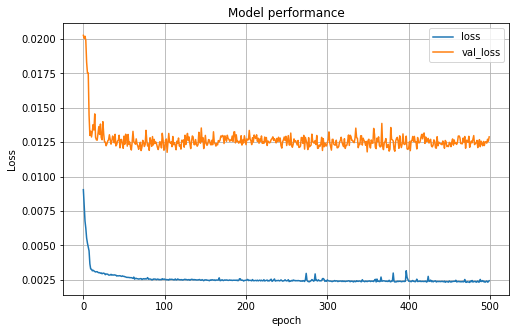

In [39]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
rmse_train, train_predict = predict_and_score(model2, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model2, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 28909.02 RMSE
Test data score: 68317.48 RMSE


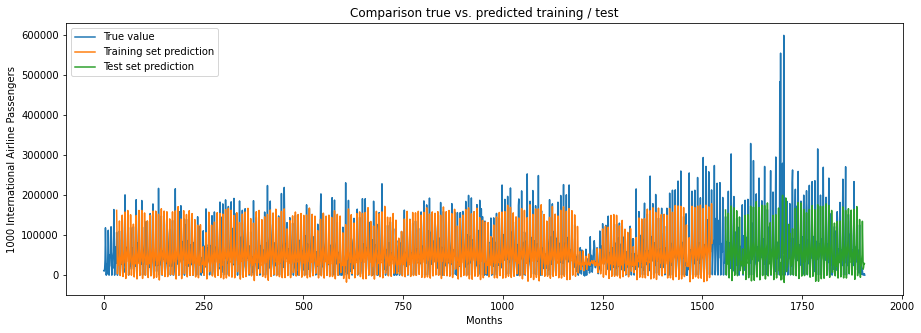

In [41]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

********************************************************************************************************************

# Build simple RNN model 

The architecture here consists of:

One input layer.
One RNN layer of 4 blocks.
One Dense layer to produce a single output.
Use MSE as loss function.

In [19]:
window_size = 3

# Define the model.
model3 = Sequential()
model3.add(SimpleRNN(4, input_shape = (window_size, 1)))
model3.add(Dense(1))

model3.compile(loss = "mean_squared_error", optimizer = "adam")

model3.summary()

# Fit the first model.
history3 = model3.fit(train_X, train_Y, epochs = 300, batch_size = 1, validation_data = (test_X, test_Y))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 4)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0090 - val_loss: 0.0218
Epoch 2/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0070 - val_loss: 0.0198
Epoch 3/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0071 - val_loss: 0.0181
Epoch 4/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0070 - val_loss: 0.0192
Epoch 5/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0070 - val_loss: 0.0186
Epoch

Epoch 74/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0197
Epoch 75/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0193
Epoch 76/300
1522/1522 [==============================] - 2s 2ms/step - loss: 0.0068 - val_loss: 0.0187
Epoch 77/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0190
Epoch 78/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0198
Epoch 79/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0197
Epoch 80/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0185
Epoch 81/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0189
Epoch 82/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0068 - val_loss: 0.0190
Epoch 83/300
1522/1522 [==============================] - 2s 1ms

1522/1522 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.0168
Epoch 231/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.0175
Epoch 232/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.0167
Epoch 233/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.0176
Epoch 234/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.0186
Epoch 235/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.0184
Epoch 236/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.0180
Epoch 237/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 0.0164
Epoch 238/300
1522/1522 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.0188
Epoch 239/300
1522/1522 [==============================] - 2s 1ms/ste

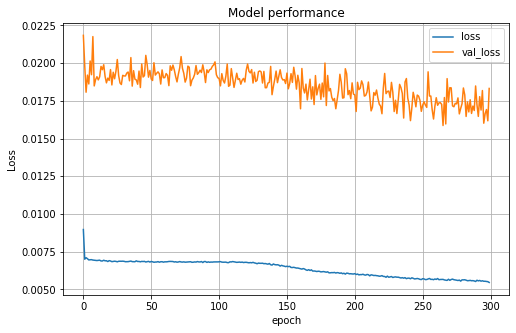

In [24]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
rmse_train, train_predict = predict_and_score(model3, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model3, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 44525.19 RMSE
Test data score: 81468.14 RMSE


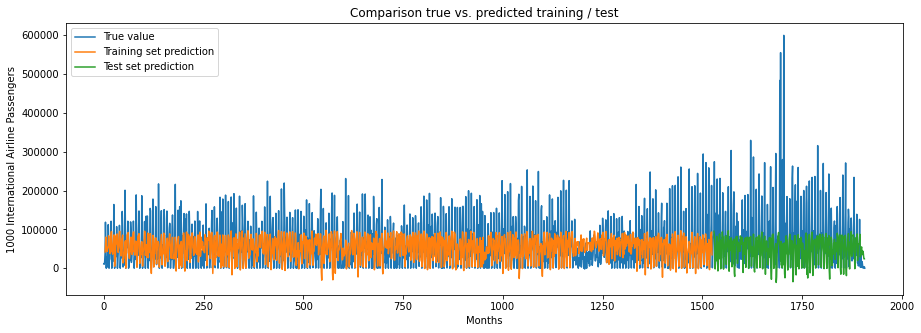

In [26]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

## Next steps and things to explore

- Work with de-trended, stationary time series. Does it improve performance?
- Different window size (multiple regression). See Example 2.
- LSTM architecture, i.e. more layers, neurons etc.
- Impact of various hyperparameters in LSTM network on prediction accuracy.
- Model selection steps to find the "best" model.

# Build XGBOOST 

In [27]:
# Create test and training sets for one-step-ahead regression.
window_size = 3
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)
print("Original training data shape:")
print(X_train.shape)
print(X_test.shape)

Original training data shape:
(1522, 3)
(378, 3)


In [28]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [29]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X).reshape(1, -1))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], pred[0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(reg, X_train, y_train)
rmse_test, test_predict = predict_and_score(reg, X_test, y_test)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 42453.53 RMSE
Test data score: 73432.01 RMSE


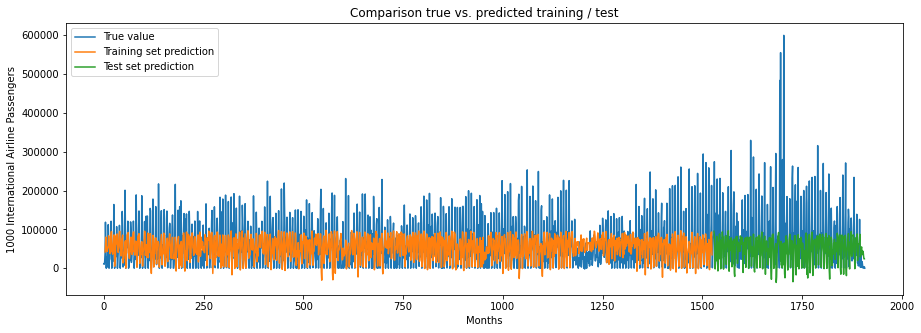

In [30]:
# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

# Build a Conv-1D 

In [31]:
# we have only 1 feature here
n_features = 1

# choose a number of time steps
n_steps = 3

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_train.shape)
print(X_test.shape)

(1522, 3, 1)
(378, 3, 1)


In [32]:
# define model
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
# cnn.add(LeakyReLU(alpha=0.1))
cnn.add(Dense(1))

cnn.compile(optimizer='adam', loss='mse')

cnn.summary()

# fit model
history_cnn = cnn.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 64)             192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
48/48 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0190
Epoch 2/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0188
Epoch 3/300
48/48 [==============================] - 0s 

Epoch 74/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0213
Epoch 75/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0213
Epoch 76/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0219
Epoch 77/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0205
Epoch 78/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0199
Epoch 79/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0207
Epoch 80/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0221
Epoch 81/300
48/48 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0209
Epoch 82/300
48/48 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0206
Epoch 83/300
48/48 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0200


48/48 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0158
Epoch 237/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0161
Epoch 238/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0165
Epoch 239/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0169
Epoch 240/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0192
Epoch 241/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0188
Epoch 242/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0176
Epoch 243/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0172
Epoch 244/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0170
Epoch 245/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0185
Epoc

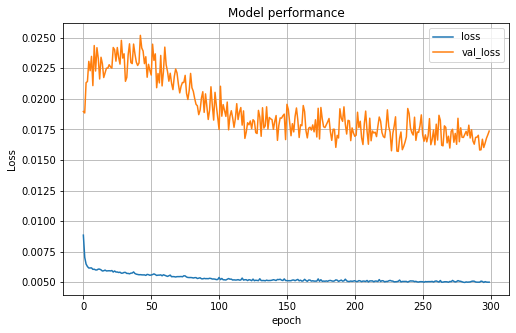

In [34]:
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
rmse_train, train_predict = predict_and_score(cnn, train_X, train_Y)
rmse_test, test_predict = predict_and_score(cnn, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 42410.49 RMSE
Test data score: 79311.88 RMSE


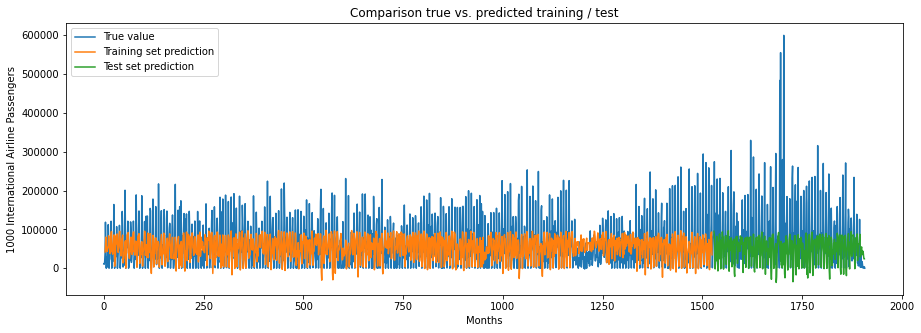

In [36]:
# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

# Scoring RMSE Results

Avec window_size de 3:

|   | LSTM | GRU | RNN | XGBOOST | CNN |
|---|---|---|---|---|---|
| train  | 27337.70| 28909.02 | 44525.19 | 42453.53 | 42410.49 |
| test  |  66297.36| 68317.48 | 81468.14 | 73432.01 | 79311.88 |

